In [ ]:
%pip uninstall prophet pystan
%pip install pystan==2.19.1.1 --no-cache-dir
%pip install prophet==1.0.0 --no-cache-dir

In [ ]:
%pip list | grep pystan
%pip list | grep prophet

WARNING: You are using pip version 21.0.1; however, version 22.1 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-3b927614-32aa-41b4-9a8e-ad83e9da6e40/bin/python -m pip install --upgrade pip' command.
pystan 3.4.0
WARNING: You are using pip version 21.0.1; however, version 22.1 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-3b927614-32aa-41b4-9a8e-ad83e9da6e40/bin/python -m pip install --upgrade pip' command.
prophet 1.0

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
import os
ENTRY_POINT = os.getcwd()
ENTRY_POINT = ENTRY_POINT[:ENTRY_POINT.rfind('/')]
os.chdir(ENTRY_POINT)
sys.path.append(ENTRY_POINT)

In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
import datetime
import itertools
import logging

# Load Data

In [3]:
PATH = './data/automl/input_df_2.csv'
df = pd.read_csv(PATH, parse_dates=['date'])
#df['date'] = pd.to_datetime(df['date'])
#cond = (df['tgt_sales_units'] > 0)
#df = df.loc[cond]
# df = df.iloc[:-1, :]
df#.head()

,date,mdip_tv,mdip_tv_hispanic,mdip_fep,mdip_youtube,mdip_display,mdip_social,mdip_search,mdip_amz_search,mdip_amz_disp,...,mdsp_olv,mdsp_pandora,mdsp_ooh,sales,avg_price,seasonality,sales_difference,flu_cases_macro,outliers,is_holiday
0,2018-01-06,383.398,0.0000,281872.0,1.002019e+06,64385371.0,0.0,212099.00000,3098036.0,69123423.0,...,0.000000,0.000000,0.000000,3.394255e+06,3.852449,1.243053e+06,0.000000,47610.0,0.00,0.0
1,2018-01-13,467.841,0.0148,200847.0,8.921308e+04,38673765.0,0.0,198104.00000,3646767.0,0.0,...,0.000000,0.000000,0.000000,3.055050e+06,3.965026,9.573552e+05,0.000000,41386.0,0.00,1.0
2,2018-01-20,268.635,0.0000,556.0,0.000000e+00,1392.0,0.0,300506.00000,5292638.0,0.0,...,0.000000,0.000000,0.000000,2.972385e+06,3.969834,6.208614e+05,0.000000,38148.0,0.00,0.0
3,2018-01-27,406.987,0.0000,1025160.0,0.000000e+00,2132567.0,0.0,310159.00000,5101203.0,0.0,...,0.000000,0.000000,0.000000,3.708384e+06,3.577980,4.282922e+05,0.000000,33328.0,0.00,0.0
4,2018-02-03,664.458,0.0000,3729945.0,0.000000e+00,14393428.0,0.0,169121.00000,4794821.0,0.0,...,0.000000,0.000000,0.000000,3.082908e+06,3.791559,2.787727e+05,0.000000,29738.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,2019-11-30,431.821,94.8146,7237523.0,1.740806e+06,32377923.0,0.0,97662.71429,2268261.0,0.0,...,110.854316,55.879334,0.218997,4.563044e+06,4.121499,1.181400e+05,0.000000,95418.0,0.00,0.0
100,2019-12-07,183.071,81.5256,5864485.0,4.287663e+06,31024843.0,0.0,87720.14286,8296046.0,0.0,...,0.000661,54.546547,0.160223,4.204151e+06,4.164285,3.586739e+05,0.000000,80559.0,0.00,0.0
101,2019-12-14,369.061,75.3235,12585756.0,4.967893e+06,29684095.0,0.0,129678.14290,6743825.0,0.0,...,0.006522,0.014480,0.038663,5.594713e+06,4.814359,7.836315e+05,0.330759,74823.0,5594713.27,0.0
102,2019-12-21,433.319,50.4880,12720995.0,3.674742e+06,27844441.0,0.0,291607.85710,695823.0,0.0,...,0.001454,0.000000,0.000000,1.234879e+07,5.052284,1.127003e+06,1.207225,78779.0,12348789.59,0.0


# 2018 Year Only

## Process Data

In [5]:
#FLTR_DATE = '(date <= "2020-01-01")|(date > "2020-12-31")'
FLTR_DATE = '(date <= "2019-01-01")'

prophet_data = df.query(FLTR_DATE)[['date', 'sales', 'flu_cases_macro', 'is_holiday']]
prophet_data = prophet_data.rename(columns = {'sales':'y', 'date':'ds'}).fillna(0)
prophet_data.head()

,ds,y,flu_cases_macro,is_holiday
0,2018-01-06,3394255.253,47610.0,0.0
1,2018-01-13,3055049.990,41386.0,1.0
2,2018-01-20,2972385.070,38148.0,0.0
3,2018-01-27,3708384.000,33328.0,0.0
4,2018-02-03,3082907.530,29738.0,0.0


## Fit model

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/hakon/.local/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/hakon/.local/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/hakon/.local/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/hakon/.local/lib/python3.8/site-packages/p

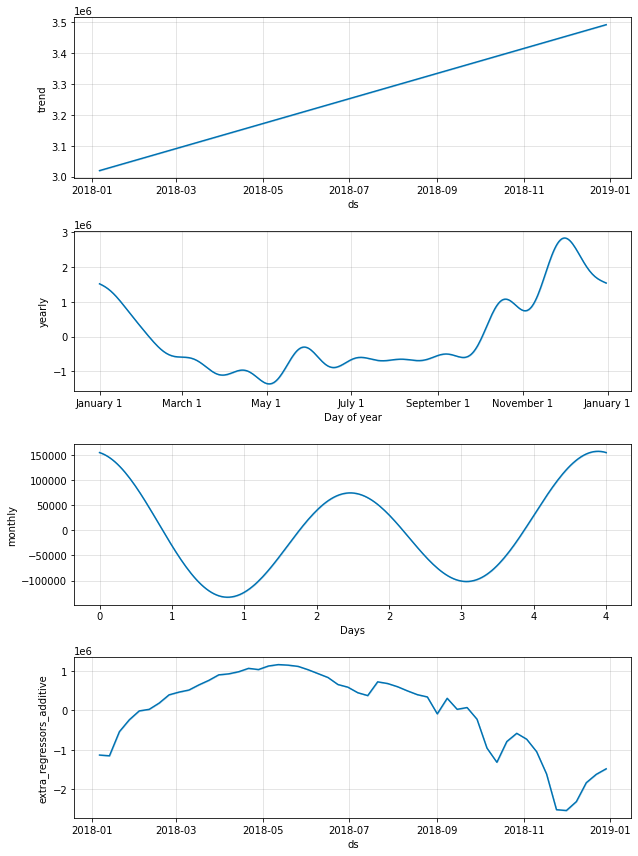

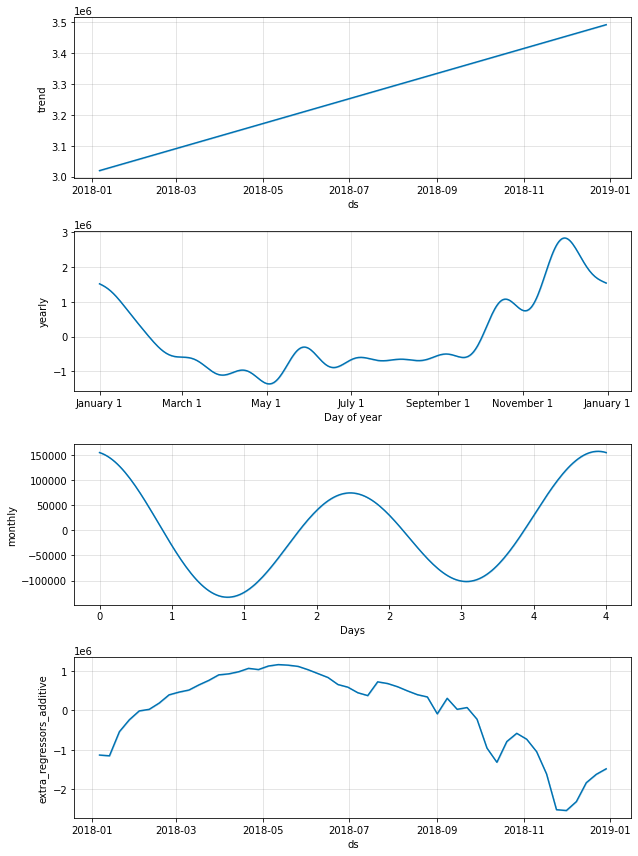

In [6]:
prophet = Prophet(yearly_seasonality=True)
prophet.add_seasonality(name='monthly', period=4.3, fourier_order=2)
prophet.add_regressor(name = "flu_cases_macro")
prophet.add_regressor(name = "is_holiday")
#prophet.fit(prophet_data[["ds", "y", "flu_cases_macro"]])
prophet.fit(prophet_data[["ds", "y", "flu_cases_macro", "is_holiday"]])
#prophet_predict = prophet.predict(prophet_data[["ds", "y", "flu_cases_macro"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y", "flu_cases_macro", "is_holiday"]])
prophet.plot_components(prophet_predict)

## Produce results

In [7]:
prophet_predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-06,3.019475e+06,3.209873e+06,3.628645e+06,3.019475e+06,3.019475e+06,396060.348382,396060.348382,396060.348382,-1.132721e+06,...,119647.836951,119647.836951,119647.836951,1.409133e+06,1.409133e+06,1.409133e+06,0.0,0.0,0.0,3.415535e+06
1,2018-01-13,3.028733e+06,2.756300e+06,3.156756e+06,3.028733e+06,3.028733e+06,-72146.402588,-72146.402588,-72146.402588,-1.151465e+06,...,-81361.763491,-81361.763491,-81361.763491,1.160681e+06,1.160681e+06,1.160681e+06,0.0,0.0,0.0,2.956587e+06
2,2018-01-20,3.037991e+06,3.013266e+06,3.413143e+06,3.037991e+06,3.037991e+06,175674.038755,175674.038755,175674.038755,-5.385644e+05,...,-111198.307427,-111198.307427,-111198.307427,8.254368e+05,8.254368e+05,8.254368e+05,0.0,0.0,0.0,3.213665e+06
3,2018-01-27,3.047250e+06,3.219144e+06,3.624321e+06,3.047250e+06,3.047250e+06,366884.721998,366884.721998,366884.721998,-2.358976e+05,...,129553.324782,129553.324782,129553.324782,4.732290e+05,4.732290e+05,4.732290e+05,0.0,0.0,0.0,3.414134e+06
4,2018-02-03,3.056508e+06,3.027783e+06,3.429694e+06,3.056508e+06,3.056508e+06,164226.627363,164226.627363,164226.627363,-1.046727e+04,...,43606.693846,43606.693846,43606.693846,1.310872e+05,1.310872e+05,1.310872e+05,0.0,0.0,0.0,3.220735e+06


In [12]:
res_seas = pd.DataFrame(prophet_predict)
res_out = res_seas.set_index("ds")[['yearly', 'monthly', 'is_holiday']]

In [13]:
COLS = res_out.columns.tolist()
COMB = []
for i in range (2, len(COLS)+1):
    COMB.extend(list(itertools.combinations(COLS, i)))
for comb in COMB:
    res_out[str(comb)] = sum([res_out[x] for x in comb])
res_out.columns = [x.replace('(', '').replace(')', '').replace(', ', '-').replace("'", "") for x in res_out.columns]
print(res_out.shape)
res_out.head()

(52, 7)


,yearly,monthly,is_holiday,yearly-monthly,yearly-is_holiday,monthly-is_holiday,yearly-monthly-is_holiday
ds,,,,,,,
2018-01-06,1.409133e+06,119647.836951,0.000000,1.528781e+06,1.409133e+06,119647.836951,1.528781e+06
2018-01-13,1.160681e+06,-81361.763491,-409574.041737,1.079319e+06,7.511066e+05,-490935.805228,6.697449e+05
2018-01-20,8.254368e+05,-111198.307427,0.000000,7.142385e+05,8.254368e+05,-111198.307427,7.142385e+05
2018-01-27,4.732290e+05,129553.324782,0.000000,6.027823e+05,4.732290e+05,129553.324782,6.027823e+05
2018-02-03,1.310872e+05,43606.693846,0.000000,1.746939e+05,1.310872e+05,43606.693846,1.746939e+05


In [14]:
# Expand the results for full 2 years
res_out = pd.concat([res_out, res_out]).reset_index(drop = True)
res_out['date'] = df['date'].copy()
res_out.set_index('date')
res_out

,yearly,monthly,is_holiday,yearly-monthly,yearly-is_holiday,monthly-is_holiday,yearly-monthly-is_holiday,date
0,1.409133e+06,119647.836951,0.000000,1.528781e+06,1.409133e+06,119647.836951,1.528781e+06,2018-01-06
1,1.160681e+06,-81361.763491,-409574.041737,1.079319e+06,7.511066e+05,-490935.805228,6.697449e+05,2018-01-13
2,8.254368e+05,-111198.307427,0.000000,7.142385e+05,8.254368e+05,-111198.307427,7.142385e+05,2018-01-20
3,4.732290e+05,129553.324782,0.000000,6.027823e+05,4.732290e+05,129553.324782,6.027823e+05,2018-01-27
4,1.310872e+05,43606.693846,0.000000,1.746939e+05,1.310872e+05,43606.693846,1.746939e+05,2018-02-03
...,...,...,...,...,...,...,...,...
99,2.827558e+06,43606.693846,0.000000,2.871165e+06,2.827558e+06,43606.693846,2.871165e+06,2019-11-30
100,2.611979e+06,-92116.717218,0.000000,2.519862e+06,2.611979e+06,-92116.717218,2.519862e+06,2019-12-07
101,2.142441e+06,-35138.711327,0.000000,2.107302e+06,2.142441e+06,-35138.711327,2.107302e+06,2019-12-14
102,1.765380e+06,51647.022006,0.000000,1.817027e+06,1.765380e+06,51647.022006,1.817027e+06,2019-12-21


In [15]:
res_out.columns

Index(['yearly', 'monthly', 'is_holiday', 'yearly-monthly',
       'yearly-is_holiday', 'monthly-is_holiday', 'yearly-monthly-is_holiday',
       'date'],
      dtype='object')

<AxesSubplot:xlabel='date'>

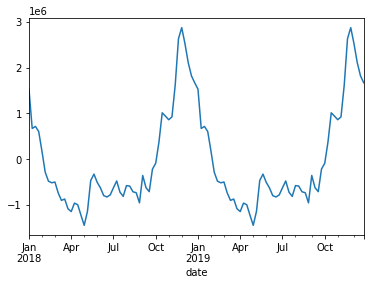

In [16]:
res_out.set_index('date')['yearly-monthly-is_holiday'].plot()

## Export results

In [17]:
PATH_OUT = './data/automl/seasonality.csv'
res_out.set_index('date').to_csv(PATH_OUT)

# 2018 and 2019 Years

## Process data

In [4]:
prophet_data = df[['date', 'sales', 'is_holiday']]
prophet_data = prophet_data.rename(columns = {'sales':'y', 'date':'ds'}).fillna(0)
prophet_data.head()

,ds,y,is_holiday
0,2018-01-06,3394255.253,0.0
1,2018-01-13,3055049.990,1.0
2,2018-01-20,2972385.070,0.0
3,2018-01-27,3708384.000,0.0
4,2018-02-03,3082907.530,0.0


## Fit model

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/hakon/.local/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/hakon/.local/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/hakon/.local/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/hakon/.local/lib/python3.8/site-packages/p

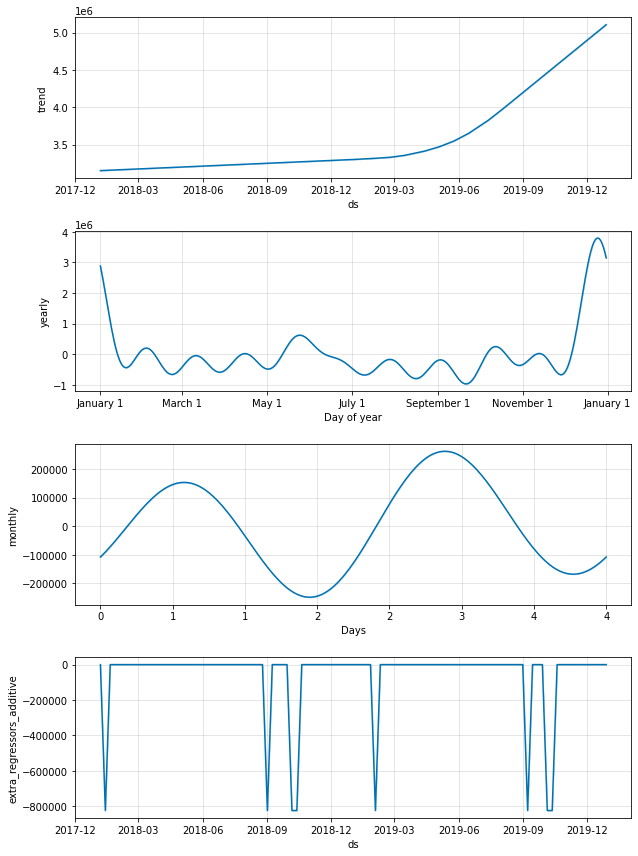

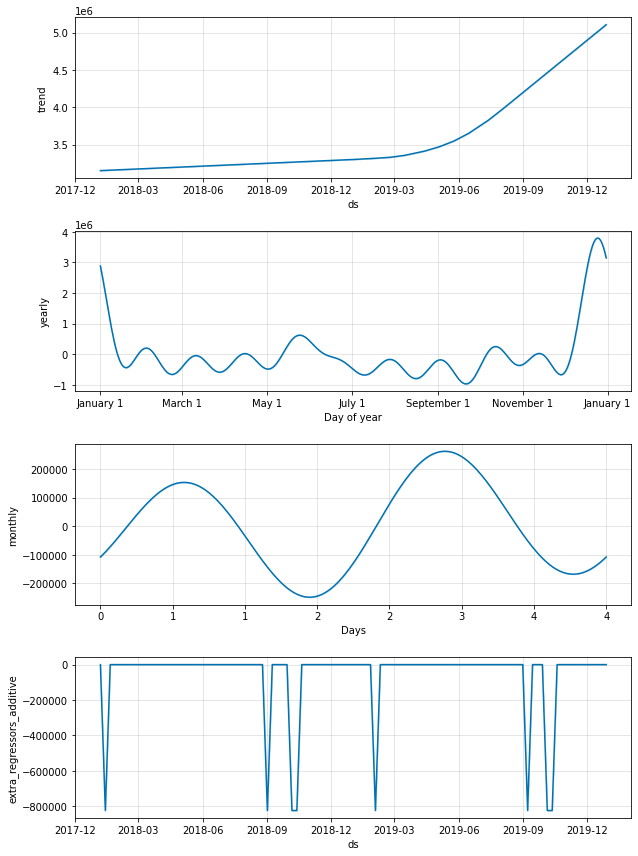

In [19]:
prophet = Prophet(yearly_seasonality=True)
prophet.add_seasonality(name='monthly', period=4.3, fourier_order=2)
# prophet.add_regressor(name = "cov_stringency")
prophet.add_regressor(name = "is_holiday")
prophet.fit(prophet_data[["ds", "y", "is_holiday"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y", "is_holiday"]])
prophet.plot_components(prophet_predict)

## Produce results

In [20]:
res_seas = pd.DataFrame(prophet_predict)
res_out = res_seas.set_index("ds")[['yearly', 'monthly', 'is_holiday']]
COLS = res_out.columns.tolist()
COMB = []
for i in range (2, len(COLS)+1):
    COMB.extend(list(itertools.combinations(COLS, i)))
for comb in COMB:
    res_out[str(comb)] = sum([res_out[x] for x in comb])
res_out.columns = [x.replace('(', '').replace(')', '').replace(', ', '-').replace("'", "") for x in res_out.columns]
print(res_out.shape)
res_out.head()

(104, 7)


,yearly,monthly,is_holiday,yearly-monthly,yearly-is_holiday,monthly-is_holiday,yearly-monthly-is_holiday
ds,,,,,,,
2018-01-06,1.672083e+06,-14788.745805,0.000000,1.657294e+06,1.672083e+06,-14788.745805,1.657294e+06
2018-01-13,8.436397e+04,261355.395302,-823198.148157,3.457194e+05,-7.388342e+05,-561842.752855,-4.774788e+05
2018-01-20,-4.365006e+05,-76238.267974,0.000000,-5.127389e+05,-4.365006e+05,-76238.267974,-5.127389e+05
2018-01-27,-9.229404e+04,-167820.156282,0.000000,-2.601142e+05,-9.229404e+04,-167820.156282,-2.601142e+05
2018-02-03,2.040430e+05,38322.551463,0.000000,2.423655e+05,2.040430e+05,38322.551463,2.423655e+05


In [21]:
# Expand the results for full 3 years
QUERY_2018 = '(ds < "2019-01-01")'
QUERY_2019 = '(ds >= "2019-01-01")'
res_out = pd.concat([res_out.query(QUERY_2018), res_out.query(QUERY_2019)]).reset_index(drop = True)
res_out['date'] = df['date'].copy()
res_out

,yearly,monthly,is_holiday,yearly-monthly,yearly-is_holiday,monthly-is_holiday,yearly-monthly-is_holiday,date
0,1.672083e+06,-14788.745805,0.000000,1.657294e+06,1.672083e+06,-14788.745805,1.657294e+06,2018-01-06
1,8.436397e+04,261355.395302,-823198.148157,3.457194e+05,-7.388342e+05,-561842.752855,-4.774788e+05,2018-01-13
2,-4.365006e+05,-76238.267974,0.000000,-5.127389e+05,-4.365006e+05,-76238.267974,-5.127389e+05,2018-01-20
3,-9.229404e+04,-167820.156282,0.000000,-2.601142e+05,-9.229404e+04,-167820.156282,-2.601142e+05,2018-01-27
4,2.040430e+05,38322.551463,0.000000,2.423655e+05,2.040430e+05,38322.551463,2.423655e+05,2018-02-03
...,...,...,...,...,...,...,...,...
99,-6.565527e+05,124223.147548,0.000000,-5.323296e+05,-6.565527e+05,124223.147548,-5.323296e+05,2019-11-30
100,8.906722e+04,-33304.547985,0.000000,5.576267e+04,8.906722e+04,-33304.547985,5.576267e+04,2019-12-07
101,1.834538e+06,-204365.973580,0.000000,1.630172e+06,1.834538e+06,-204365.973580,1.630172e+06,2019-12-14
102,3.455077e+06,81155.559345,0.000000,3.536233e+06,3.455077e+06,81155.559345,3.536233e+06,2019-12-21


<AxesSubplot:xlabel='date'>

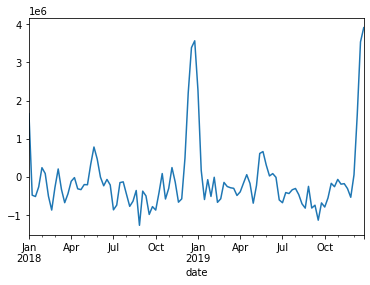

In [23]:
res_out.set_index('date')['yearly-monthly-is_holiday'].plot()

## Export results

In [24]:
PATH_OUT = './data/automl/seasonality_18_19.csv'
res_out.set_index('date').to_csv(PATH_OUT)

In [ ]:
PATH_OUT = '/dbfs/FileStore/MMX/seasonality_20192021base_wm.csv'
df = pd.read_csv(PATH_OUT)
df

Out[11]:

,date,yearly,monthly,hldy_hol,yearly-monthly,yearly-hldy_hol,monthly-hldy_hol,yearly-monthly-hldy_hol
0,2019-01-05,589.361024,314.718171,-1703.143628,904.079195,-1113.782604,-1388.425457,-799.064433
1,2019-01-12,269.172425,-391.741668,0.000000,-122.569243,269.172425,-391.741668,-122.569243
2,2019-01-19,-14.261463,239.128878,0.000000,224.867415,-14.261463,239.128878,224.867415
3,2019-01-26,-367.651244,32.274887,-1703.143628,-335.376357,-2070.794872,-1670.868741,-2038.519985
4,2019-02-02,-823.428197,-291.972491,0.000000,-1115.400688,-823.428197,-291.972491,-1115.400688
...,...,...,...,...,...,...,...,...
151,2021-11-27,1767.512041,-154.458397,-1703.143628,1613.053644,64.368413,-1857.602025,-90.089984
152,2021-12-04,2112.091375,-168.553911,0.000000,1943.537464,2112.091375,-168.553911,1943.537464
153,2021-12-11,2241.190034,401.020577,0.000000,2642.210611,2241.190034,401.020577,2642.210611
154,2021-12-18,1950.913312,-362.504079,0.000000,1588.409233,1950.913312,-362.504079,1588.409233


Out[20]:

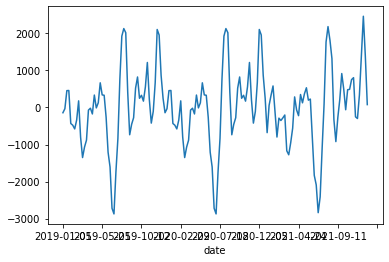

<AxesSubplot:xlabel='date'>

In [ ]:
df.set_index('date')['yearly-monthly'].plot()

# 2018 + 2019